# Image Classification with Convolutional Neural Networks in Keras
## Computer Vision and Image Processing - Lab Session 6
### Prof: Luigi Di Stefano, luigi.distefano@unibo.it
### Tutor: Pierluigi Zama Ramirez, pierluigi.zama@unibo.it - Alex Costanzino, alex.costanzino@unibo.it

A **Convolutional Neural Network** (CNN) is a type of network architecture for deep learning algorithms, and it is widely employed in tasks that involve the processing of pixel data.

<p align="center">
  <img src="LabSession6Images/cnn.png" width="768">
</p>

A CNN for image classification usually consists in three main layers: 
* A **convolutional layer** - for feature extraxtion;
* A **pooling layer** - for dimensionality reduction;
* A **fully connected layer** - for classification. 

## The image classification task
Image classification is the task of *assigning a class label to an entire image*.
In its simplest form, images are expected to include no more than one class (mutual exclusivity).

<p align="center">
  <img src="LabSession6Images/image_classification.png" width="768">
</p>

Image classification models take an image as input and return a (crisp) prediction about which class the image belongs to.

## Framework for Neural Networks

There are several frameworks for designing neural networks based in Python, among them:
* [Caffe](https://caffe.berkeleyvision.org/);
* [Lasagne](https://github.com/Lasagne/Lasagne);
* TensorFlow;
* Keras;
* [MXNet](https://github.com/apache/mxnet);
* [PyTorch](https://pytorch.org/).

Each framework has its own goodies and drawbacks.

### Keras & Tensorflow
[TensorFlow](https://www.tensorflow.org/) is a machine learning framework employed to design, build, and train deep learning models. 
[Keras](https://keras.io/) is a simple API - built on top of TensorFlow - developed for fast experimentation.

Since Keras is integrated into Tensorflow, we usually refer to one name rather than another interchangeably.

Together they provide to the user intuitive interfaces for:
* **Layers** (i.e. linear layer, convolutional layer);
* **Activation functions** (i.e. sigmoid, ReLU, softmax);
* **Loss functions** (i.e. cross-entropy, KL divergence);
* **Regularizers**;
* **Metrics** (i.e. accuracy, recall);
* **Optimizers** (i.e. SGD, RMSprop);
* **Models**;
* **Datasets**;

... and much more.

For further details refer to the [official documentation](https://keras.io/api/).

#### Pro and Cons

For the scope of this session Tensorflow and Keras are adopted since:
* The desing of neural network is straightforward, it suffices to stack layers;
* The documentation is rather good and updated frequently;
* There is a big community for support and model sharing (TensorFlow is a Google product).

However, there are also some problems, such as:
* There is less flexibility and usability compared to other frameworks;
* Lower speed with respect to competitors;
* There are some incosistencies: TensorFlow provides homonyms that share similar names but different implementations, which makes it confusing to remember and use.

## Implementing an Image Classifier with Keras

A very *high-level pipeline* for experimenting with machine learning models is devised as follows:
1. **Setup**;
2. **Data preparation**, in which the data are managed, loaded, pre-processed - if necessary - and usually inspected for debugging purposes;
3. **Model building**, in which the model is built, layer-by-layer thanks to the high-level interfaces provided by Keras;
4. **Model training**, in which loss functions, metrics and optimizers are embedded to the model and the model parameters are optimized;
5. **Model evaluation**, in which the trained model is applied to the test data to infer the new labels and to assess them.

### 1. Setup

We import the usual libraries along with TensorFlow and fix the random seeds to a known value in order to make the experiments repeatable and check if everything it is correct.

#### Modules and submodules
Note that, unlike OpenCV, TensorFlow is *higly modularized*. Each model component has its own module and has to be accessed or imported following the path to the module.

Let us say we want to use the convolutional layer of Keras `Conv2D`, we cannot directly call it as `keras.Conv2D` or `tensorflow.2D`, first of all since Keras itself it is a module of tensorflow, and so we need to access it as `tensorflow.keras`, but also because `Conv2D` is under the `layers` module of Keras. So, to correctly call `Conv2D` we can either:

1. Import it from the submodule and assign it:
```
        tensorflow.keras.layers import Conv2D
        x = Conv2D(*args)
```
2. Directly assign it:
```
        x = tensorflow.keras.layers.Conv2D(*args)
```

For the specific location of each object refer to the [official documentation](https://keras.io/api/).

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Fixed random seed for repeatability.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

### 2. Dataset preparation

#### Datasets and dataloaders
The `tf.keras.datasets` module provides some ready-to-use toy datasets for several different machine learning task. 
Such datasets are already-vectorized in Numpy format and they are usually employed for debugging or creating simple models.

However, Keras is also endowed with data loading utilities, located in `tf.keras.utils`, which help you go from raw data on disk to a `tf.data.Dataset` object that can be used to efficiently train a model.
These loading utilites can be combined with preprocessing layers to futher transform your input dataset before training (i.e. data augmentation, normalization).

*Example*

Let us say you have 10 folders, each containing 1000 images from a different category, and you want to train a classifier that maps an image to its category. Then, your training data folder would look like this:
```
training_data/
....dog/
.......dog_0001.jpg
.......dog_0002.jpg
.
.
.
....cat/
.......cat_0001.jpg
.......cat_0002.jpg
.
.
.
```
You could simply do:

```
from tensorflow.utils import image_dataset_from_directory
train_ds = image_dataset_from_directory(directory = 'path/to/your/data',
                                        labels = 'inferred',
                                        label_mode = 'categorical',
                                        batch_size = 32,
                                        image_size = (256, 256))
```

However, for this session we will use some Keras dataset.

##### Fashion-MNIST
**Fashion-MNIST** is a dataset of Zalando's article images, consisting of a training set of 60k samples and a test set of 10k samples. Each sample is a 28x28 grayscale image, associated with a label from 10 different mutually exclusive classes.

<p align="center">
  <img src="LabSession6Images/fashion-mnist.png" width="512">
</p>

#### Data loading
To retrieve the dataset it suffices to import the dataset and call the `load_data()` method on it.
The method will download, unzip and process the dataset in order to obtain a tuple for the training data and a tuple for the test data.

In [2]:
from tensorflow.keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data();

#### Data inspection
There are several things that we can inspect in order to ensure that everything it is fine.
For instance we can start by checking whether the expected number of samples and size of the images are correct:

In [3]:
n_train, w_train, h_train = x_train.shape
n_test, w_test, h_test = x_test.shape

unique_labels = np.unique(y_train)
n_classes = len(unique_labels) # N.B. np.unique(x) returns the list of unique values inside the array x.

print(f"There are {n_train} samples in the training set, with size ({w_train},{h_train}).")
print(f"There are {n_test} samples in the test set with, size ({w_test},{h_test}).")
print(f"There are {n_classes} different classes.")
print(f"The unique labels are {unique_labels}.")

There are 60000 samples in the training set, with size (28,28).
There are 10000 samples in the test set with, size (28,28).
There are 10 different classes.
The unique labels are [0 1 2 3 4 5 6 7 8 9].


Note that checking the number of classes by checking the number of unique values in the training set means that we are hypothesizing that the class distribution of the input data it is the same of the output data, i.e. every class in the test set is also in the training set.

Let us then extract a random index to visually inspect some images of the training set:

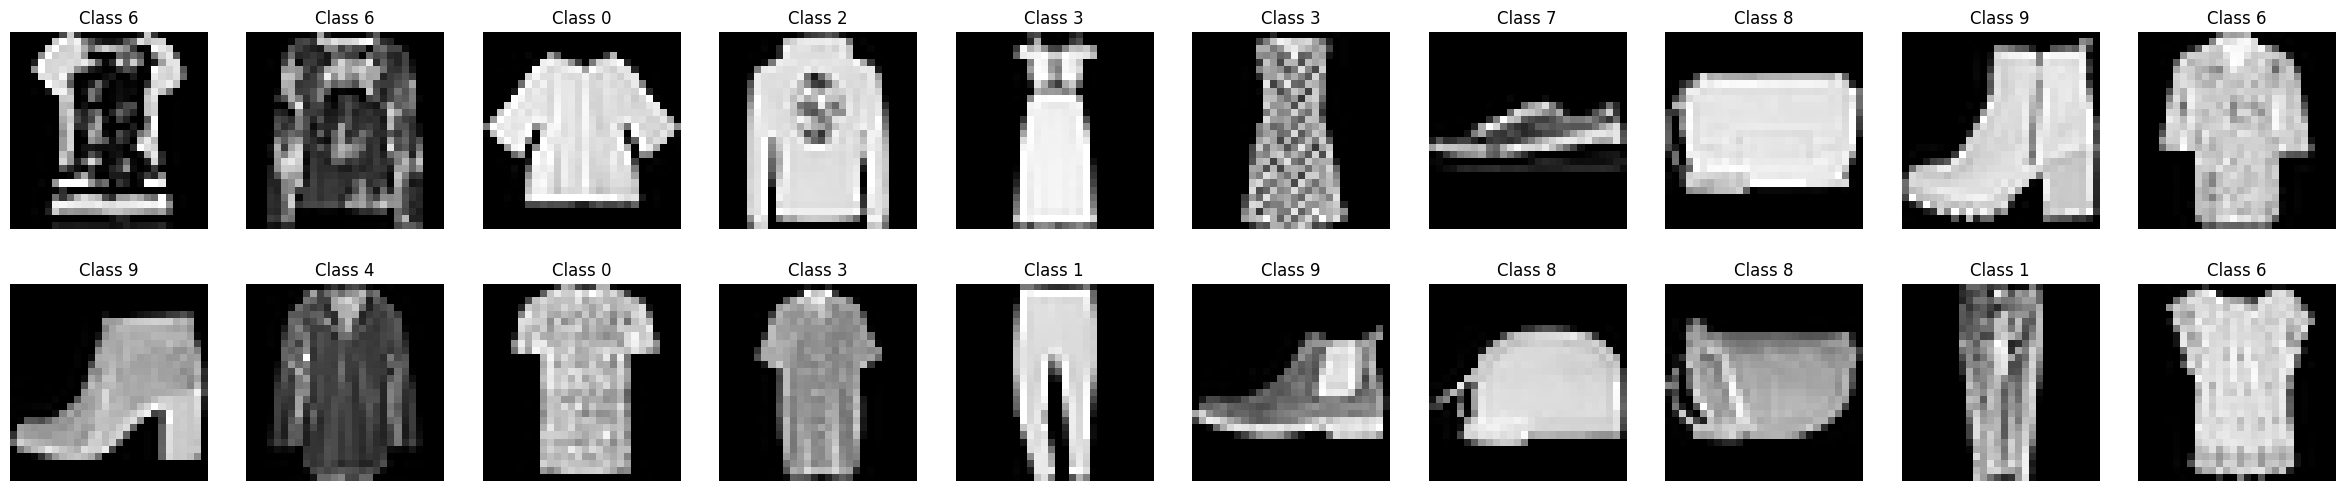

In [4]:
rand_idx = np.random.randint(0, x_train.shape[0])

fig, ax = plt.subplots(2, 10, figsize=(30, 6))
ax = ax.ravel()

for i in range(20):
    rand_idx = np.random.randint(0, x_train.shape[0])

    ax[i].set_axis_off()
    
    ax[i].set_title(f"Class {y_train[rand_idx]}")
    ax[i].imshow(x_train[rand_idx], vmin = x_train[rand_idx].min(), vmax = x_train[rand_idx].max(), cmap = "gray")

Then, we can check the range of these images:

In [5]:
print(f"The images are in the range [{x_train.min()},{x_train.max()}].")

The images are in the range [0,255].


Of course we know that these images are all in the range $[0,255]$.

#### Data normalization
In general it is a good practice to normalize the input data of a machine learning model (for certain kind of model it can be also mandatory) for two main reasons:
1. After normalization all data lies in the same interval and so metric and losses based on similarities make sense;
2. Smaller data begets smaller weights and hence a more efficient learning.

In this case a simple rescaling in the $[0,1]$ range it suffices:

In [6]:
x_train = x_train / x_train.max()
x_test = x_test / x_test.max()

print(f"The new range of the images is [{x_train.min()},{x_train.max()}].")

The new range of the images is [0.0,1.0].


Then, since these images are grayscale we need to add a dimension that takes into account the dimensionality of the channel:

In [7]:
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print(f"The new shape of the feature matrix is: {x_train.shape}.")

The new shape of the feature matrix is: (60000, 28, 28, 1).


In case of RGB images this is not necessary since they already have 3 channels.

### 3. Model building

As mentioned before, we need to extract from the `layers` submodule the layers of interest:

In [8]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout

Here listed some simplified interfaces of layers that we will employ:
* `Input(shape)` - we can specify the shape of the input, in the form (h,w,c);
* `Flatten()`;
* `Dense(units, activation)` - we can specify the number of neurons - in the case of classification equal to the number of classes - and the type of activation function of the output;
* `MaxPooling2D(pool_size)` - we can specify the size of the pooling - bidimensional since we are using a 2d pooiling;
* `Dropout(rate)` - we can specify the percentage of blacked-out neurons.
* `Conv2D(filters, kernel_size, activation)` - we can specify the number of stacked filters, the size of the kernel - bidimensional since we are using a 2d convolution, and the type of activation function of the output.


<p align="center">
  <img src="LabSession6Images/conv2d_.png" width="512" class="center">
</p>

In [9]:
input_shape = x_train.shape[1:]
print(f"The input shape of the CNN is {input_shape}.")

The input shape of the CNN is (28, 28, 1).


We can leverage on Keras sequential model to easily build our neural network as a stack of layers:

In [10]:
model = Sequential(
    [   
        # Input layer.
        Input(shape = input_shape),

        # Convolutions with subsequent pooling.
        Conv2D(filters = 32, kernel_size = (3, 3), activation = "relu"),
        MaxPooling2D(pool_size = (2, 2)),
        Conv2D(filters = 64, kernel_size = (3, 3), activation = "relu"),
        MaxPooling2D(pool_size = (2, 2)),

        # Classification head.
        Flatten(),
        Dropout(rate = 0.15),
        Dense(units = n_classes, activation = "softmax"),
    ]
)

Once that the net is built we can use the `summary()` method to obtain a nice overview of the model:

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)              0

### 4. Model training

As before, we need to extract from the `optimizers` and `losses` submodules the objects of interest:

In [12]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy

opt = SGD(learning_rate = 1e-3)
loss_fcn = SparseCategoricalCrossentropy()

And we add them to the model:

In [13]:
model.compile(loss = loss_fcn, 
              optimizer = opt, 
              metrics = ["accuracy"])

Then, we set some others hyperparameters, such as:
* `batch_size` - number of samples that will be propagated through the network at each iteration;
* `epochs` - number of complete pass on the training data;

and also:
* `val_split_percentage` - percentage of training data to reserve as validation at each iteration.

In [14]:
batch_size = 128
epochs = 20
val_split_percentage = 0.1

In [18]:
model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, validation_split = val_split_percentage);

Epoch 1/20
329/329 [==============================] - 6s 17ms/step - loss: 0.7937 - accuracy: 0.7110 - val_loss: 0.7323 - val_accuracy: 0.7414
Epoch 2/20
329/329 [==============================] - 6s 17ms/step - loss: 0.7824 - accuracy: 0.7137 - val_loss: 0.7173 - val_accuracy: 0.7446
Epoch 3/20
329/329 [==============================] - 6s 18ms/step - loss: 0.7755 - accuracy: 0.7163 - val_loss: 0.7103 - val_accuracy: 0.7489
Epoch 4/20
329/329 [==============================] - 6s 17ms/step - loss: 0.7638 - accuracy: 0.7181 - val_loss: 0.7025 - val_accuracy: 0.7524
Epoch 5/20
329/329 [==============================] - 6s 17ms/step - loss: 0.7537 - accuracy: 0.7237 - val_loss: 0.6956 - val_accuracy: 0.7511
Epoch 6/20
329/329 [==============================] - 6s 18ms/step - loss: 0.7462 - accuracy: 0.7258 - val_loss: 0.6944 - val_accuracy: 0.7444
Epoch 7/20
329/329 [==============================] - 6s 17ms/step - loss: 0.7381 - accuracy: 0.7299 - val_loss: 0.6797 - val_accuracy: 0.7569

### 5. Model evaluation

We can also visualize the model accuracy and loss for the training and the validation sets. 
Since the validation set is class-balanced, accuracy provides an unbiased representation of the model's performance.

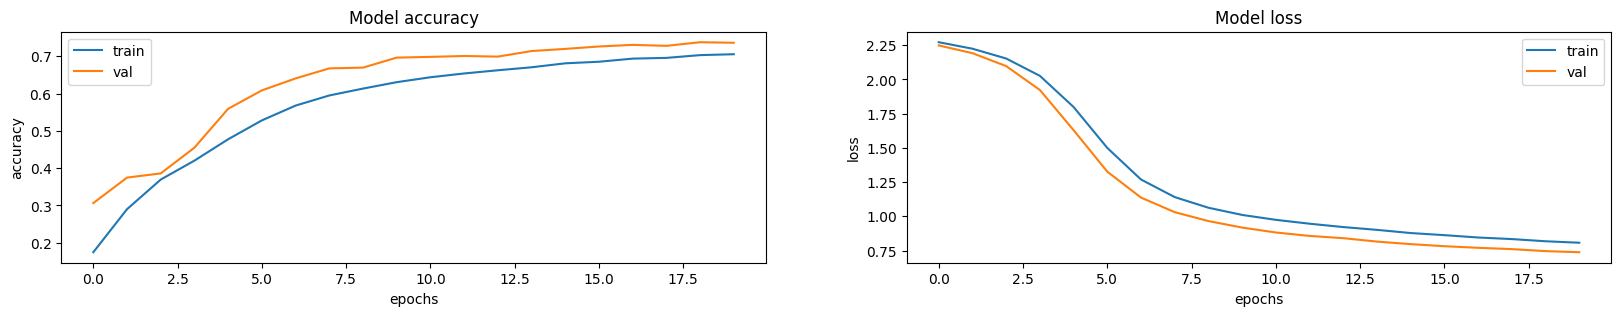

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["accuracy", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])


Then, we can perform inference on the test data and assess the metrics:

In [17]:
test_loss, test_metric = model.evaluate(x_test, y_test, verbose = 1)
print(f"The test loss is {test_loss:.4f}, the test accuracy is {test_metric:.4f}.")

313/313 [==============================] - 1s 2ms/step - loss: 0.7607 - accuracy: 0.7258
The test loss is 0.7607, the test accuracy is 0.7258.
